# Impute personal income

In [ ]:
import numpy as np
import pandas as pd
import random
import cv2
import os
from scipy.stats import randint
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler


random_seed = 1234

For a better performance predicting income is split into a classification and regression task. First, a random forst classifier is trained to predict if a individuum has a income (1) or no income (1). Second, a random forest regressor is trained for all individuals with an income > 0. Finally, both models are combined to imputed the missing income.

In [2]:
# Set up dir

dir_h = "YOUR_DIRECTORY/"

In [ ]:
income_imp = pd.read_pickle(dir_h + "income_imp.pkl")
income_imp["age"] = np.where(income_imp.age.isna(), income_imp.age.median(), income_imp.age)
income_imp["edyear"] = np.where(income_imp.edyear.isna(), income_imp.edyear.median(), income_imp.edyear)
income_imp

In [10]:
data_to_impute = income_imp[income_imp.pers_income.isna()]
train_test_data = income_imp[~income_imp.pers_income.isna()]

## Classification task no income/ income

In [12]:
train_test_data_class = train_test_data.copy()
train_test_data_class["pers_income"] = np.where(train_test_data_class.pers_income==0, 0 ,1)
train_test_data_class["pers_income"] = np.where(train_test_data_class.pers_income==0, 0 ,1)
train_test_data_class.pers_income.value_counts(normalize=True)

pers_income
1    0.629335
0    0.370665
Name: proportion, dtype: float64

In [13]:
x_train, x_test, y_train, y_test = train_test_split(np.array(train_test_data_class.drop(columns=["idpers","pers_income"])), np.array(train_test_data_class.pers_income), test_size=0.2, random_state=random_seed)

In [14]:
def evaluate(y_hat, y_true):
    print("ACC",accuracy_score(y_hat, y_true))
    print("F1",f1_score(y_hat, y_true))
    print("AUC",roc_auc_score(y_hat, y_true))

In [15]:
rf = RandomForestClassifier(random_state=random_seed)

cv_hat = cross_val_predict(rf, x_train, y_train, cv=10, n_jobs=6)
evaluate(cv_hat, y_train)

ACC 0.9908735332464146
F1 0.9927489317622685
AUC 0.9921364934077648


#### Performance on test data

In [71]:
rf_cl = RandomForestClassifier(random_state=random_seed)
rf_cl.fit(x_train, y_train)

y_hat = rf_cl.predict(x_test)
evaluate(y_hat, y_test)

ACC 0.9905475880052151
F1 0.9926896899420217
AUC 0.9918689961878187


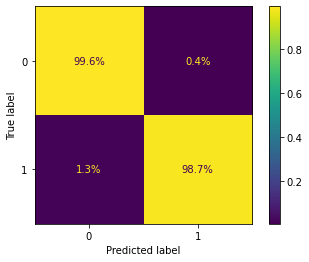

In [15]:
ConfusionMatrixDisplay.from_predictions(y_hat, y_test, normalize="true", values_format=".1%")
plt.show()

## Regression task income continuous

In [72]:
train_test_data_reg = train_test_data[train_test_data.pers_income > 0]

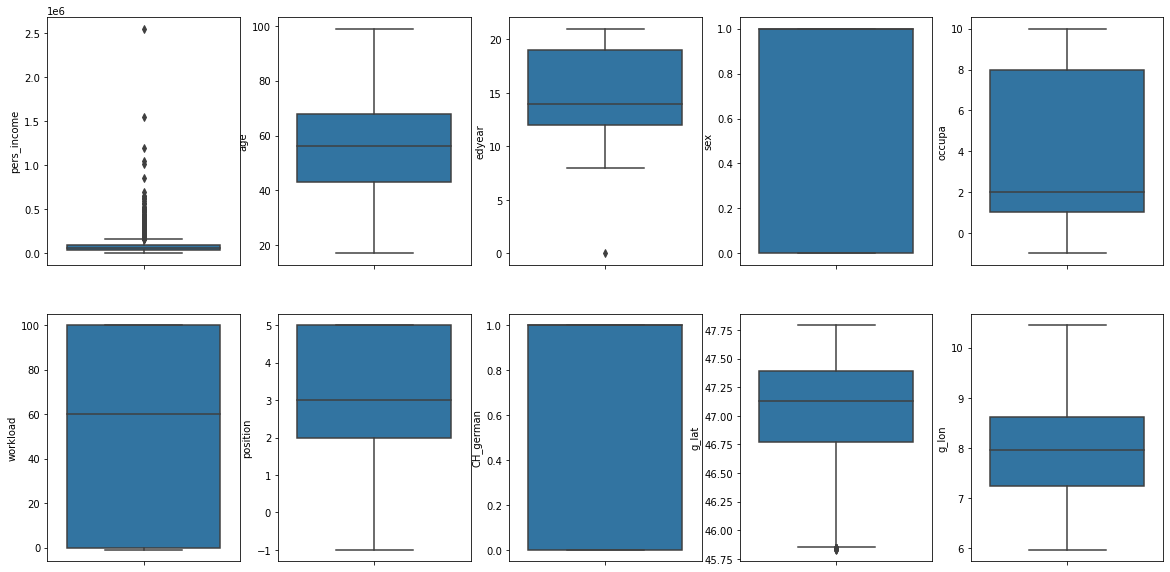

In [17]:
data = train_test_data_reg.drop(columns=["workload_mis", "position_mis", "occupa_mis"])
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index])
    index += 1

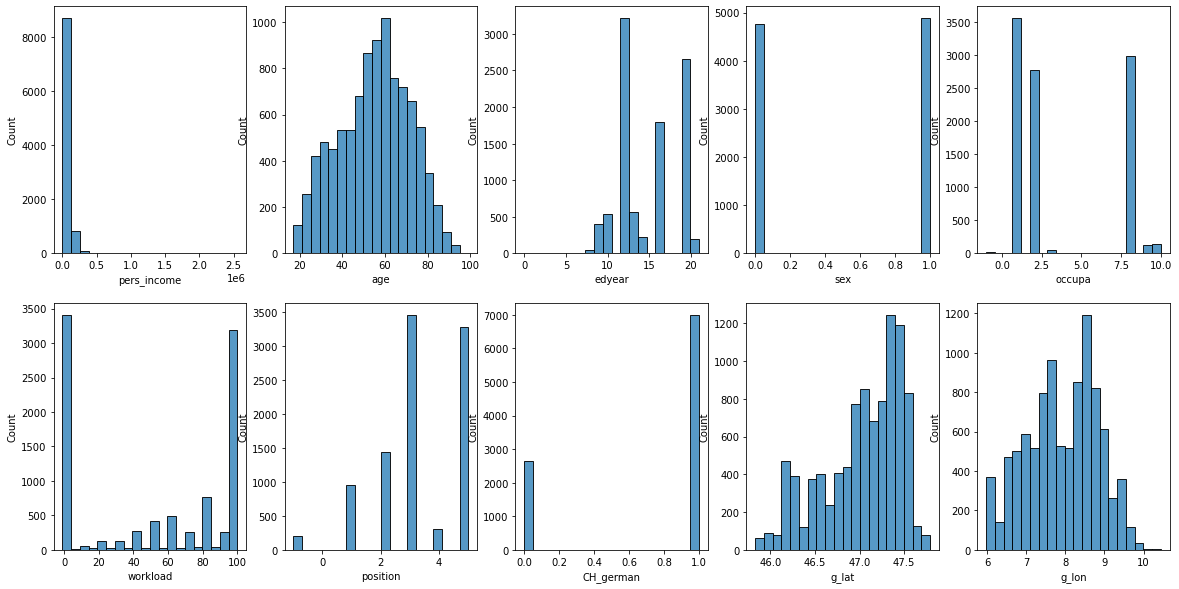

In [18]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.histplot(v, ax=axs[index], bins=20)
    index += 1

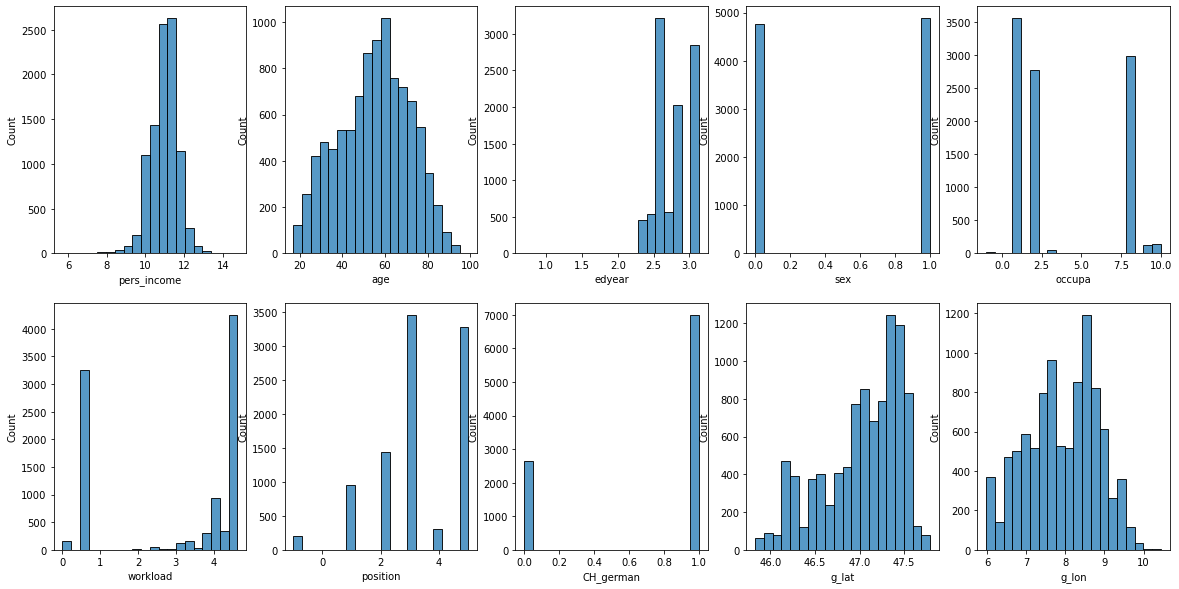

In [19]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    if k in ["pers_income","edyear", "workload"]:
        sns.histplot(np.log(v+2), ax=axs[index], bins=20)
    else:
        sns.histplot(v, ax=axs[index], bins=20)
    index += 1

In [73]:
train_test_data_reg = train_test_data_reg.assign(pers_income = np.log(train_test_data_reg.pers_income+1))

In [74]:
x_train, x_test, y_train, y_test = train_test_split(np.array(train_test_data_reg.drop(columns="pers_income")), np.array(train_test_data_reg.pers_income), test_size=0.2, random_state=random_seed)

In [75]:
def evaluate(y_hat, y_true):
    print("P", pearsonr(y_true, y_hat))
    print("R2", r2_score(y_true, y_hat))
    print("MAE", mean_absolute_error(y_true, y_hat))
    print("RMSE", mean_squared_error(y_true, y_hat, squared=False))

### Predicting median

C:\Users\bahr\Anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\bahr\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


P (nan, nan)
R2 -0.014414442138097838
MAE 0.5504704338998008
RMSE 0.737034374247337


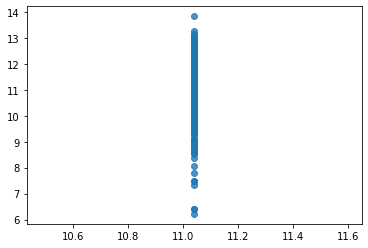

In [76]:
y_hat = np.full((len(y_test),1), np.median(y_train))
evaluate(y_hat, y_test)

sns.regplot(y_hat, y_test)
plt.show()

### Ridge regression

In [23]:
ridge = Ridge()

cv_hat = cross_val_predict(ridge, x_train, y_train, cv=10, n_jobs=6)
evaluate(cv_hat, y_train)

P (0.6491264158442116, 0.0)
R2 0.4213629557671893
MAE 0.3803567939583821
RMSE 0.5387858301083872


### Random forest

In [24]:
rf = RandomForestRegressor(n_estimators=500, random_state=random_seed, n_jobs=6)

cv_hat = cross_val_predict(rf, x_train, y_train, cv=10, n_jobs=6)
evaluate(cv_hat, y_train)

P (0.6636434412710926, 0.0)
R2 0.43471860442231236
MAE 0.37828288466126386
RMSE 0.5325316136748623


#### Hyperparameter tuning random forest

In [ ]:
param_grid = {"n_estimators": [200, 500, 1000, 1500],
             "max_depth": [1, 3, 5, 7, 9, 11, 13]}

cv_search = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=6)
cv_search.fit(x_train, y_train)
print(cv_search.best_params_, -cv_search.best_score_)

In [ ]:
param_grid = {"n_estimators": [200],
              "min_samples_leaf": [1, 5, 10, 20, 50, 100], 
              "max_depth": [1, 3]}

cv_search = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=6)
cv_search.fit(x_train, y_train)
print(cv_search.best_params_, -cv_search.best_score_)

In [ ]:
param_grid = {"n_estimators": [1200, 1300, 1400, 1500, 1600],
             "max_depth": [9, 10, 11, 12, 13],
             "min_samples_leaf": [1, 2, 3, 4, 5, 10], 
             "max_features": [0.6, 0.5, 0.4, 0.3, 0.2]}

cv_search = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=6)
cv_search.fit(x_train, y_train)
print(cv_search.best_params_, -cv_search.best_score_)

In [ ]:
param_grid = {"n_estimators": [200, 400, 1000, 1100, 1200, 1300],
             "max_depth": [10, 11, 12],
             "min_samples_leaf": [1, 2, 3], 
             "max_features": [0.5, 0.4, 0.3]}

cv_search = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=6)
cv_search.fit(x_train, y_train)
print(cv_search.best_params_, -cv_search.best_score_)

In [25]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=11,
                   min_samples_leaf=1, max_features=0.4, random_state=random_seed, n_jobs=6)

cv_hat = cross_val_predict(rf, x_train, y_train, cv=10, n_jobs=6)
evaluate(cv_hat, y_train)

P (0.6879489346182632, 0.0)
R2 0.47290089956316406
MAE 0.3608636068549881
RMSE 0.5142321034299263


#### Performance on test data

P (0.6774530121717276, 1.3844872867923266e-259)
R2 0.4576049697695782
MAE 0.3747952242900898
RMSE 0.5389368531790318


C:\Users\bahr\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


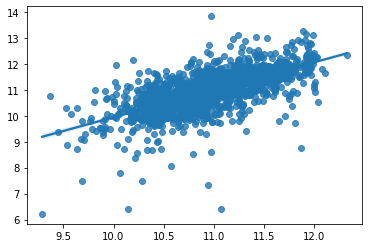

In [77]:
rf_reg = RandomForestRegressor(n_estimators=1000, max_depth=11,
                   min_samples_leaf=1, max_features=0.4, random_state=random_seed, n_jobs=6)
rf_reg.fit(x_train, y_train)

y_hat = rf_reg.predict(x_test)
evaluate(y_hat, y_test)

sns.regplot(y_hat, y_test)
plt.show()

### Extreme gradient boost

In [28]:
xgb = XGBRegressor(booster="gbtree", random_state=random_seed, n_jobs=6)

cv_hat = cross_val_predict(xgb, x_train, y_train, cv=10, n_jobs=6)
evaluate(cv_hat, y_train)

P (0.6630968387704452, 0.0)
R2 0.43210867082096804
MAE 0.3793023947436476
RMSE 0.5337595610105004


#### Hypertuning XGB

In [ ]:
xgb = XGBRegressor(booster="gbtree", objective="reg:squarederror", tree_method="exact", random_state=random_seed, n_jobs=6)

param_grid = {"n_estimators": [200, 400, 600, 800],
             "max_depth": [1, 3, 5, 7, 9, 11],
             "min_child_weight": [1, 2, 3, 4, 6], 
             "gamma": [0.1, 0.5, 1, 1.2, 2]}

cv_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=6)
cv_search.fit(x_train, y_train)
print(cv_search.best_params_, -cv_search.best_score_)

In [ ]:
xgb = XGBRegressor(booster="gbtree", objective="reg:squarederror", tree_method="exact", random_state=random_seed, n_jobs=6)

param_grid = {"n_estimators": [100, 200, 300, 400],
             "max_depth": [1, 2, 3, 4, 5, 10],
             "min_child_weight": [2, 3, 4], 
             "gamma": [0.01, 0.1, 0.2, 0.5, 1]}

cv_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=6)
cv_search.fit(x_train, y_train)
print(cv_search.best_params_, -cv_search.best_score_)

In [ ]:
xgb = XGBRegressor(booster="gbtree", objective="reg:squarederror", tree_method="exact", 
                   gamma=1, max_depth=4, min_child_weight=4, n_estimators=100, random_state=random_seed, n_jobs=6)

param_grid = {"subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

cv_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=6)
cv_search.fit(x_train, y_train)
print(cv_search.best_params_, -cv_search.best_score_)

In [ ]:
xgb = XGBRegressor(booster="gbtree", objective="reg:squarederror", tree_method="exact", 
                   gamma=1, max_depth=4, min_child_weight=4, n_estimators=100, random_state=random_seed, n_jobs=6)

param_grid = {"subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

cv_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=6)
cv_search.fit(x_train, y_train)
print(cv_search.best_params_, -cv_search.best_score_)

In [ ]:
xgb = XGBRegressor(booster="gbtree", objective="reg:squarederror", tree_method="exact", 
                   gamma=1, max_depth=4, min_child_weight=4, n_estimators=100, 
                   colsample_bytree=1.0, subsample=1.0, random_state=random_seed, n_jobs=6)

param_grid = {"reg_alpha": [0, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9],
             "reg_lambda": [0, 8, 9, 10, 11, 12]}

cv_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=6)
cv_search.fit(x_train, y_train)
print(cv_search.best_params_, -cv_search.best_score_)

In [ ]:
xgb = XGBRegressor(booster="gbtree", objective="reg:squarederror", tree_method="exact", 
                   gamma=1, max_depth=4, min_child_weight=4, n_estimators=100, 
                   colsample_bytree=1.0, subsample=1.0, reg_alpha=1.5, reg_lambda=10, random_state=random_seed, n_jobs=6)

param_grid = {"n_estimators": [100, 200, 400, 800, 1000, 2000, 3000, 6000],
             "learning_rate": [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.0001]}

cv_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=6)
cv_search.fit(x_train, y_train)
print(cv_search.best_params_, -cv_search.best_score_)

In [ ]:
xgb = XGBRegressor(booster="gbtree", objective="reg:squarederror", tree_method="exact", 
                   gamma=1, max_depth=4, min_child_weight=4, n_estimators=100, 
                   colsample_bytree=1.0, subsample=1.0, reg_alpha=1.5, reg_lambda=10, random_state=random_seed, n_jobs=6)

param_grid = {"n_estimators": [300, 400, 500],
             "learning_rate": [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.0001]}

cv_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=6)
cv_search.fit(x_train, y_train)
print(cv_search.best_params_, -cv_search.best_score_)

In [29]:
xgb = XGBRegressor(booster="gbtree", objective="reg:squarederror", tree_method="exact", 
                   gamma=1, max_depth=4, min_child_weight=4, n_estimators=300, learning_rate=0.05, 
                   colsample_bytree=1.0, subsample=1.0, reg_alpha=1.5, reg_lambda=10, random_state=random_seed, n_jobs=6)

cv_hat = cross_val_predict(xgb, x_train, y_train, cv=10, n_jobs=6)
evaluate(cv_hat, y_train)

P (0.6875488547041028, 0.0)
R2 0.4723753981846842
MAE 0.36056715859607447
RMSE 0.5144883762635339


#### Performance on test data

P (0.6758988946045488, 5.853829960578967e-258)
R2 0.45607626556609726
MAE 0.3752680575614481
RMSE 0.5396957975778571


C:\Users\bahr\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


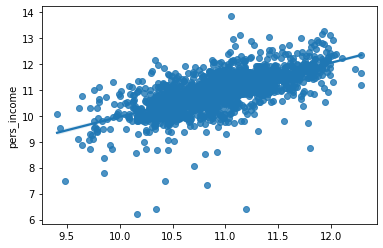

In [30]:
xgb_reg = XGBRegressor(booster="gbtree", objective="reg:squarederror", tree_method="exact", 
                   gamma=1, max_depth=4, min_child_weight=4, n_estimators=300, learning_rate=0.05, 
                   colsample_bytree=1.0, subsample=1.0, reg_alpha=1.5, reg_lambda=10, random_state=random_seed, n_jobs=6)
xgb_reg.fit(x_train, y_train)

y_hat = xgb_reg.predict(x_test)
evaluate(y_hat, y_test)

sns.regplot(y_hat, y_test)
plt.show()

## Impute missings on income

Since random forest outperformed Extreme Gradient Boost, it is used to predict if a observation has an income at all and if so the amount of it.

In [78]:
data_impute = np.array(data_to_impute.drop(columns=["idpers", "pers_income"]))
data_impute.shape

(4639, 12)

In [80]:
def impute_income(data):
    y_hat = rf_cl.predict(data)
    if y_hat == 1:
        y_hat = np.exp(rf_reg.predict(data))
        
    return y_hat

In [81]:
y_hat = np.array([impute_income(x.reshape(1, -1)) for x in data_impute])

In [ ]:
data_to_impute = data_to_impute.assign(pers_income_imp = y_hat)
data_to_impute

In [92]:
income_imp = pd.concat([data_to_impute, train_test_data], axis=0)
income_imp["pers_income_imp"] = np.where(income_imp.pers_income_imp.isna(), income_imp.pers_income, income_imp.pers_income_imp)

In [94]:
income_imp = income_imp[["idpers", "pers_income_imp"]]
income_imp.to_pickle(dir_h + "income_imputed.pkl")

=> go back to file ```SHP_data_preparation.ipynb```